CODE BLOCK: 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/ERA/Session_7")

In [ ]:
from utils import plot_samples, plot_accuracy_metrics
from models import *

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA Available? True
cuda


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    # transforms.Resize((28, 28)),
    # transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)
# train_data = datasets.MNIST('../data', train=True, download=True)
# test_data = datasets.MNIST('../data', train=False, download=True)

CODE BLOCK: 5

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

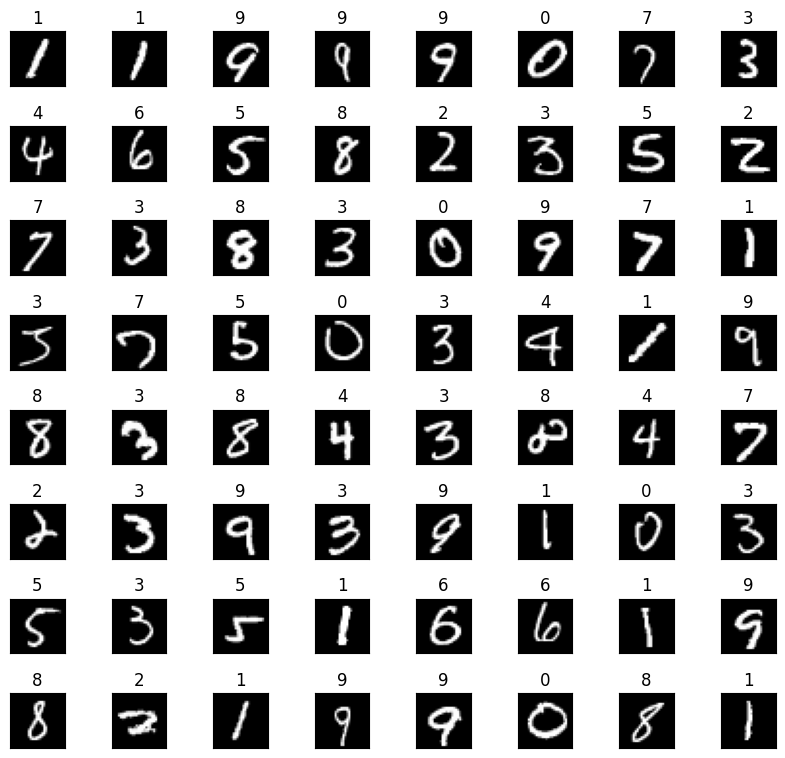

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))
plot_samples(batch_data,batch_label)

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model_4().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,320
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
           Dropout-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,168
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

CODE BLOCK: 8

In [ ]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [ ]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            # loss_fn = nn.CrossEntropyLoss(reduction='sum')
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
# criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  # scheduler.step()

Epoch 1


Train: Loss=0.1535 Batch_id=117 Accuracy=81.63: 100%|██████████| 118/118 [00:13<00:00,  8.45it/s]


Test set: Average loss: 0.1602, Accuracy: 58209/60000 (97.02%)

Epoch 2


Train: Loss=0.0878 Batch_id=117 Accuracy=97.05: 100%|██████████| 118/118 [00:15<00:00,  7.55it/s]


Test set: Average loss: 0.0786, Accuracy: 58918/60000 (98.20%)

Epoch 3


Train: Loss=0.0490 Batch_id=117 Accuracy=97.93: 100%|██████████| 118/118 [00:15<00:00,  7.66it/s]


Test set: Average loss: 0.0556, Accuracy: 59144/60000 (98.57%)

Epoch 4


Train: Loss=0.1126 Batch_id=117 Accuracy=98.27: 100%|██████████| 118/118 [00:15<00:00,  7.76it/s]


Test set: Average loss: 0.0510, Accuracy: 59125/60000 (98.54%)

Epoch 5


Train: Loss=0.0511 Batch_id=117 Accuracy=98.45: 100%|██████████| 118/118 [00:14<00:00,  8.08it/s]


Test set: Average loss: 0.0391, Accuracy: 59382/60000 (98.97%)

Epoch 6


Train: Loss=0.0642 Batch_id=117 Accuracy=98.61: 100%|██████████| 118/118 [00:15<00:00,  7.85it/s]


Test set: Average loss: 0.0337, Accuracy: 59457/60000 (99.09%)

Epoch 7


Train: Loss=0.0491 Batch_id=117 Accuracy=98.73: 100%|██████████| 118/118 [00:14<00:00,  8.01it/s]


Test set: Average loss: 0.0485, Accuracy: 59163/60000 (98.61%)

Epoch 8


Train: Loss=0.0068 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:14<00:00,  7.96it/s]


Test set: Average loss: 0.0274, Accuracy: 59545/60000 (99.24%)

Epoch 9


Train: Loss=0.0537 Batch_id=117 Accuracy=98.91: 100%|██████████| 118/118 [00:16<00:00,  7.25it/s]


Test set: Average loss: 0.0265, Accuracy: 59558/60000 (99.26%)

Epoch 10


Train: Loss=0.0328 Batch_id=117 Accuracy=98.99: 100%|██████████| 118/118 [00:14<00:00,  8.02it/s]


Test set: Average loss: 0.0237, Accuracy: 59625/60000 (99.38%)

Epoch 11


Train: Loss=0.0154 Batch_id=117 Accuracy=98.96: 100%|██████████| 118/118 [00:14<00:00,  8.01it/s]


Test set: Average loss: 0.0228, Accuracy: 59618/60000 (99.36%)

Epoch 12


Train: Loss=0.0733 Batch_id=117 Accuracy=99.09: 100%|██████████| 118/118 [00:14<00:00,  8.11it/s]


Test set: Average loss: 0.0214, Accuracy: 59659/60000 (99.43%)

Epoch 13


Train: Loss=0.0078 Batch_id=117 Accuracy=99.08: 100%|██████████| 118/118 [00:14<00:00,  8.18it/s]


Test set: Average loss: 0.0188, Accuracy: 59708/60000 (99.51%)

Epoch 14


Train: Loss=0.0298 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:14<00:00,  8.16it/s]


Test set: Average loss: 0.0209, Accuracy: 59642/60000 (99.40%)

Epoch 15


Train: Loss=0.0169 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:14<00:00,  8.17it/s]


Test set: Average loss: 0.0178, Accuracy: 59718/60000 (99.53%)

Epoch 16


Train: Loss=0.0120 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:14<00:00,  8.24it/s]


Test set: Average loss: 0.0174, Accuracy: 59716/60000 (99.53%)

Epoch 17


Train: Loss=0.0352 Batch_id=117 Accuracy=99.21: 100%|██████████| 118/118 [00:14<00:00,  8.10it/s]


Test set: Average loss: 0.0179, Accuracy: 59707/60000 (99.51%)

Epoch 18


Train: Loss=0.0147 Batch_id=117 Accuracy=99.20: 100%|██████████| 118/118 [00:15<00:00,  7.39it/s]


Test set: Average loss: 0.0185, Accuracy: 59668/60000 (99.45%)

Epoch 19


Train: Loss=0.0548 Batch_id=117 Accuracy=99.30: 100%|██████████| 118/118 [00:14<00:00,  8.14it/s]


Test set: Average loss: 0.0146, Accuracy: 59770/60000 (99.62%)

Epoch 20


Train: Loss=0.0081 Batch_id=117 Accuracy=99.31: 100%|██████████| 118/118 [00:14<00:00,  8.11it/s]


Test set: Average loss: 0.0129, Accuracy: 59816/60000 (99.69%)



CODE BLOCK: 11

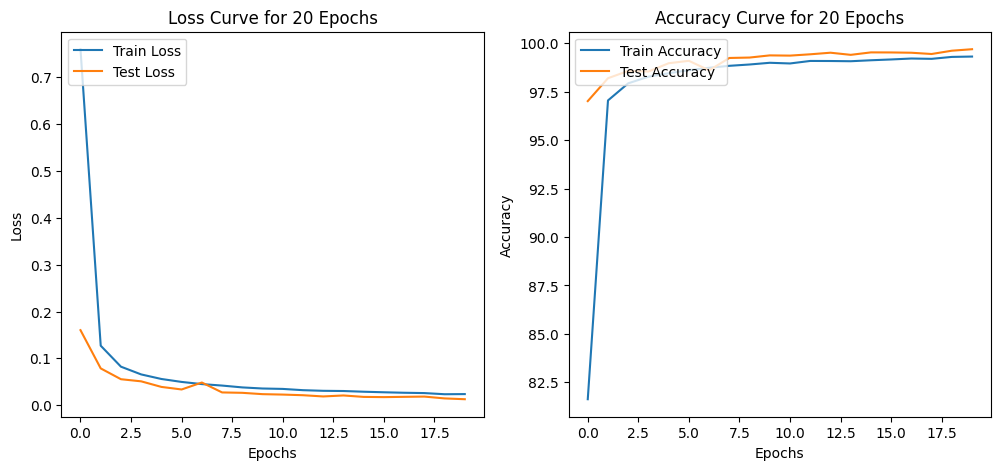

In [ ]:
plot_accuracy_metrics(train_losses,train_acc,test_losses,test_acc)